**Team Members:**

Stylianos Sidiropoulos (stysi607)

Vasileia Kampouraki (vaska979)

# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [0]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()  # Get an 8-bit grayscale bit-depth, 512 x 512 derived image for easy use in demos 

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [0]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter, boundary='symm', mode='same')
filterResponseSobelX = signal.convolve2d(image, sobelX, boundary='symm', mode='same')
filterResponseSobelY = signal.convolve2d(image, sobelY, boundary='symm', mode='same')

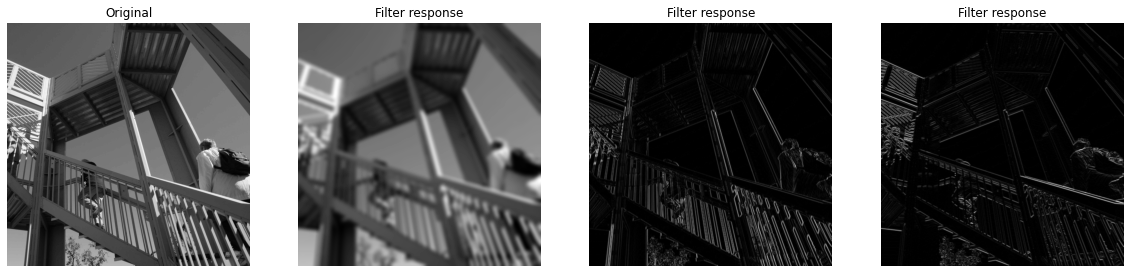

In [34]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

**Answer 1:** Gaussian filter blurs the image, SobelX filter emphasising edges in the x-axis whereas SobelY filter in the y-axis.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

**Answer 2:** Running `image.shape`, we see that the original image is (512, 512). Running `len(image.shape)` we get 2, so it has a single channel. A color image normally has 3 channels each for the colors red, green and blue.

Question 3: What is the size of the different filters?

**Answer 3:** Gaussian filter has a size of (15,15,1). Both Sobel filters have a size 3x3.

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

**Answer 4:** If mode 'same' is used the size of the filter response will increase or remain the same which in this case is 512x512.

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

**Answer 5:** The size of the Gaussian filter response is 498x498 and the size of the SobelX and SobelY filters is 510x510. If mode is set to 'valid', then the convolution performed is unpadded, which means that it performs convolution on the pixels of the input image. That means that the size of the output image will be smaller than the input one. So the size of the valid filter response = original image size - (valid filter size - 1).

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?

**Answer 6:** Because when mode 'valid' is used, no padding is applied on the images, which means that the images will become smaller in every layer and if we have many layers the size of the images may shrink.


In [35]:
# Your code for checking sizes of image and filter responses

print(image.shape)
print(filterResponseGauss.shape)
print(filterResponseSobelX.shape)
print(filterResponseSobelY.shape)

# change mode to 'valid'
filterResponseGauss2 = signal.convolve2d(image, gaussFilter, boundary='symm', mode='valid')
print(filterResponseGauss2.shape)


(512, 512)
(512, 512)
(512, 512)
(512, 512)
(498, 498)


##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [0]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 

**Answer 7:** The extra (last) dimension is for the number of channels the filter will have (red, green, blue so 3 channels)

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

**Answer 8:** No, actually Conv2D performs cross correlation.

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

**Answer 9:** GPU is about 58 times faster than the CPU.

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

**Answer 10:** In this case the GPU is only x1 faster than the CPU, which means that they both do the calculations at the same time. Compared to 100 images, this is lower. The larger the batch size, the larger the difference in the performance between GPU and CPU. 

In [78]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 100

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.129304173999799
GPU (s):
0.053277726000033
GPU speedup over CPU: 58x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [38]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

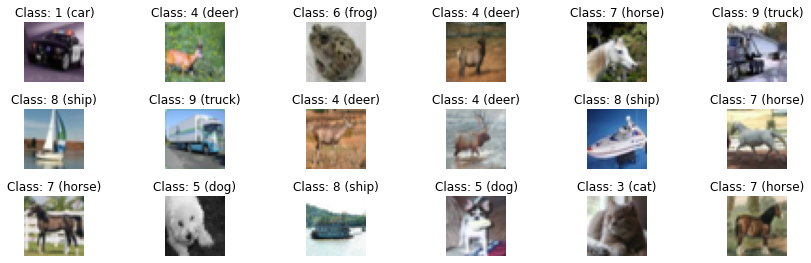

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [40]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval= train_test_split(Xtrain,Ytrain, test_size=0.25)

# Print the size of training data, validation data and test data
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)
print(Xtest.shape)
print(Ytest.shape)

(7500, 32, 32, 3)
(7500, 1)
(2500, 32, 32, 3)
(2500, 1)
(2000, 32, 32, 3)
(2000, 1)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [0]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [42]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print('Ytrain shape before "hot encoding" is: {}'.format(Ytrain.shape))
print('Yval shape before "hot encoding" is: {}'.format(Yval.shape))
print('Ytest shape before "hot encoding" is: {}'.format(Ytest.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain)
Yval = to_categorical(Yval)
Ytest = to_categorical(Ytest)



# Print shapes after converting the labels
print('Ytrain shape after "hot encoding" is: {}'.format(Ytrain.shape))
print('Yval shape after "hot encoding" is: {}'.format(Yval.shape))
print('Ytest shape after "hot encoding" is: {}'.format(Ytest.shape))


Ytrain shape before "hot encoding" is: (7500, 1)
Yval shape before "hot encoding" is: (2500, 1)
Ytest shape before "hot encoding" is: (2000, 1)
Ytrain shape after "hot encoding" is: (7500, 10)
Yval shape after "hot encoding" is: (2500, 10)
Ytest shape after "hot encoding" is: (2000, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters=n_filters, kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):   
        n_filters= 2*n_filters
        model.add(Conv2D(filters=n_filters,kernel_size=(3,3),padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size =(2,2)))
    
    # Add flatten layer
    model.add(Flatten())

    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes, activation='relu'))
        model.add(BatchNormalization())
        if use_dropout == True:
            model.add(Dropout(rate=0.5))
        
    # Add final dense layer
    model.add(Dense(10, activation='softmax'))
   
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer= Adam(lr = learning_rate),metrics=['accuracy'])
    
    return model

In [0]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [45]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape =  (32,32,3)
seed(123)

# Build model
model1 = build_CNN(input_shape=input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain,Ytrain, batch_size=batch_size, verbose=2, validation_data=(Xval,Yval), epochs=epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 1s - loss: 2.7896 - accuracy: 0.3372 - val_loss: 1.9866 - val_accuracy: 0.3188
Epoch 2/20
 - 1s - loss: 1.5765 - accuracy: 0.4784 - val_loss: 1.7714 - val_accuracy: 0.3680
Epoch 3/20
 - 1s - loss: 1.2256 - accuracy: 0.5697 - val_loss: 1.5081 - val_accuracy: 0.4700
Epoch 4/20
 - 1s - loss: 1.0853 - accuracy: 0.6196 - val_loss: 1.3998 - val_accuracy: 0.4864
Epoch 5/20
 - 1s - loss: 0.9678 - accuracy: 0.6601 - val_loss: 1.3825 - val_accuracy: 0.5380
Epoch 6/20
 - 1s - loss: 0.8856 - accuracy: 0.6867 - val_loss: 1.3168 - val_accuracy: 0.5440
Epoch 7/20
 - 1s - loss: 0.7920 - accuracy: 0.7205 - val_loss: 1.4041 - val_accuracy: 0.5344
Epoch 8/20
 - 1s - loss: 0.7176 - accuracy: 0.7493 - val_loss: 1.5111 - val_accuracy: 0.5524
Epoch 9/20
 - 1s - loss: 0.6683 - accuracy: 0.7645 - val_loss: 1.5993 - val_accuracy: 0.5492
Epoch 10/20
 - 1s - loss: 0.5842 - accuracy: 0.7953 - val_loss: 1.6407 - val_accuracy: 0.5532
Epoch 11/20
 - 1s - l

In [46]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 45us/step
Test loss: 3.0730
Test accuracy: 0.5330


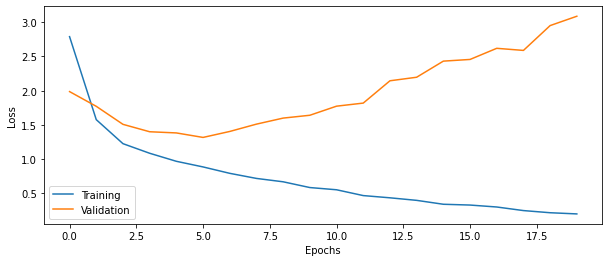

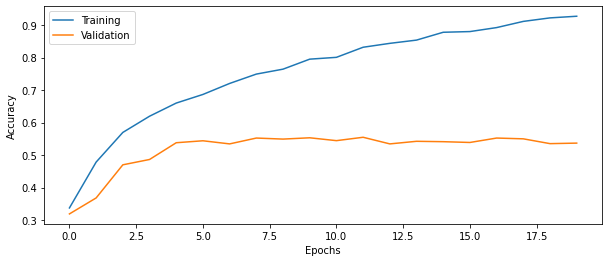

In [47]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 11: How big is the difference between training and test accuracy?

**Answer 11:** The difference between training and test accuracy is almost 40%.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

**Answer 12:** For a size of 100, GPU is at 70% utilization. GPU memory used is 11023MiB.

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

**Answer 13:** Batch size can't exceed the number of training data. Our training samples are 7,500 which means that the maximum batch size we can use is 7,500. 

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [48]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape =  (32,32,3)
seed(123)

# Build model
model2 = build_CNN(input_shape=input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain,Ytrain, batch_size=batch_size, verbose=2, validation_data=(Xval,Yval), epochs=epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 1s - loss: 1.6358 - accuracy: 0.4152 - val_loss: 1.9821 - val_accuracy: 0.3032
Epoch 2/20
 - 1s - loss: 1.2491 - accuracy: 0.5555 - val_loss: 2.0743 - val_accuracy: 0.3316
Epoch 3/20
 - 1s - loss: 1.0310 - accuracy: 0.6296 - val_loss: 1.5234 - val_accuracy: 0.4852
Epoch 4/20
 - 1s - loss: 0.8563 - accuracy: 0.6921 - val_loss: 1.3460 - val_accuracy: 0.5608
Epoch 5/20
 - 1s - loss: 0.6601 - accuracy: 0.7661 - val_loss: 1.6218 - val_accuracy: 0.5256
Epoch 6/20
 - 1s - loss: 0.5037 - accuracy: 0.8232 - val_loss: 1.6969 - val_accuracy: 0.5656
Epoch 7/20
 - 1s - loss: 0.3628 - accuracy: 0.8771 - val_loss: 1.8841 - val_accuracy: 0.5496
Epoch 8/20
 - 1s - loss: 0.2690 - accuracy: 0.9091 - val_loss: 2.2257 - val_accuracy: 0.5312
Epoch 9/20
 - 1s - loss: 0.2140 - accuracy: 0.9271 - val_loss: 2.1334 - val_accuracy: 0.5500
Epoch 10/20
 - 1s - loss: 0.1686 - accuracy: 0.9437 - val_loss: 2.4736 - val_accuracy: 0.5416
Epoch 11/20
 - 1s - l

In [49]:
# Evaluate the trained model on test set, not used in training or validation
score =  model2.evaluate(Xtest, Ytest, batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 48us/step
Test loss: 2.9155
Test accuracy: 0.5725


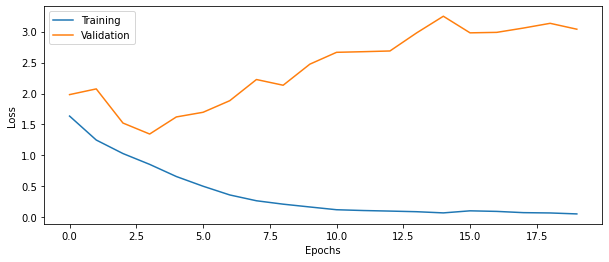

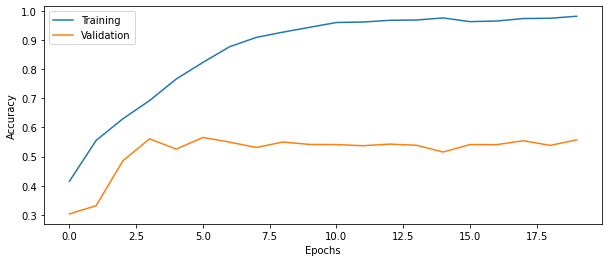

In [50]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [51]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)
seed(123)

# Build model
model3 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain,Ytrain, batch_size=batch_size, verbose=2, validation_data=(Xval,Yval), epochs=epochs)

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 2s - loss: 1.7150 - accuracy: 0.3736 - val_loss: 2.0060 - val_accuracy: 0.3440
Epoch 2/20
 - 1s - loss: 1.3703 - accuracy: 0.4985 - val_loss: 1.7692 - val_accuracy: 0.4212
Epoch 3/20
 - 1s - loss: 1.1845 - accuracy: 0.5701 - val_loss: 1.6237 - val_accuracy: 0.4620
Epoch 4/20
 - 1s - loss: 1.0224 - accuracy: 0.6276 - val_loss: 1.3727 - val_accuracy: 0.5408
Epoch 5/20
 - 1s - loss: 0.8846 - accuracy: 0.6931 - val_loss: 1.3570 - val_accuracy: 0.5600
Epoch 6/20
 - 1s - loss: 0.7260 - accuracy: 0.7407 - val_loss: 1.4543 - val_accuracy: 0.5716
Epoch 7/20
 - 1s - loss: 0.5857 - accuracy: 0.7900 - val_loss: 1.8207 - val_accuracy: 0.5536
Epoch 8/20
 - 1s - loss: 0.4798 - accuracy: 0.8307 - val_loss: 1.7156 - val_accuracy: 0.5732
Epoch 9/20
 - 1s - loss: 0.3694 - accuracy: 0.8707 - val_loss: 1.7987 - val_accuracy: 0.5688
Epoch 10/20
 - 1s - loss: 0.2745 - accuracy: 0.9017 - val_loss: 2.3550 - val_accuracy: 0.5456
Epoch 11/20
 - 1s - l

In [52]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest, batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 50us/step
Test loss: 2.5584
Test accuracy: 0.5880


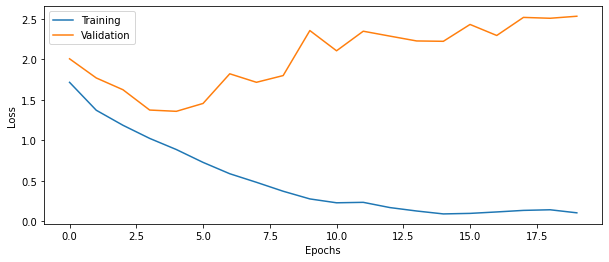

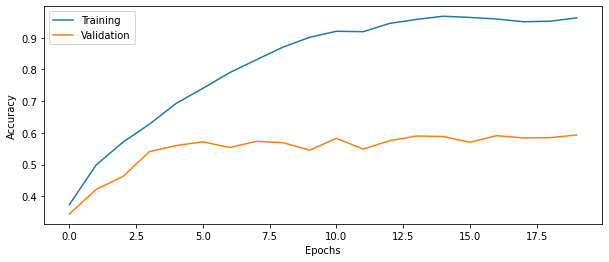

In [53]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

**Answer 14:** The network has 124,180 trainable parameters. The 4th convolutional layer contains most of the parameters(73856)

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

**Answer 15:**  According to the documentation a Conv2D layer gets as input a 4D tensor with shape `(batch, channels, rows, columns)` and has as output a 4D tensor with shape `(batch, filters, new_rows, new_columns)`. The dimensions of input and output are 4, as expected.
Generally, a conv2D layer takes as an input an image and applies the filter on each color channel and then sums the results. The output of a Conv2D is equal to the width of the image - width of the filter + 1, if stride=1. The depth will be equal to the number of filters.

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

**Answer 16:** Yes batch size is always first. Only, 'channels','rows','cols' can change order depending on which data_format is chosen('channels_first' or
'channels_last').

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

**Answer 17:**  128 channels will be in the output.

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

**Answer 18:** The number of parameters is equal to number of filters * (shape of width of the filter * height of the filter + 1). So for example in our case, looking at the summary of model 3, the first conv2D layer has 448 parameters because (3x3x3 + 1)*16 = 448.

Question 19: How does MaxPooling help in reducing the number of parameters to train?

**Answer 19:** Every time the filter passes through an image, MaxPooling is taking the maximum value in every slide. So, in each slide of the filter over a part of the image, one value is returned. That's how MaxPooling performs dimensionality reduction.


In [54]:
# Print network architecture

model3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 64)        

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

**Answer 20:** Without dropout model 3 achieved a test accuracy of  0.5880. When we used dropout for model 4 the test accuracy increases very little, 0.6080.

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

**Answer 21:** Except for Dropout, another type of regularization that can be applied is Batch Normalization. We can also use L1 and L2 regularization. To add L2 regularization in a convolutional layer we set to the parameters 'kernel_regularizer','bias_regularizer' and 'activity_regularizer' the *tf.keras.regularizers.l2* with a penalty factor in the conv2D function.


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [74]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)
seed(123)

# Build model
model4 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain,Ytrain, batch_size=batch_size, verbose=2, validation_data=(Xval,Yval), epochs=epochs)

Train on 10000 samples, validate on 2500 samples
Epoch 1/20
 - 2s - loss: 1.9712 - accuracy: 0.3062 - val_loss: 2.2891 - val_accuracy: 0.2560
Epoch 2/20
 - 1s - loss: 1.5493 - accuracy: 0.4321 - val_loss: 1.7128 - val_accuracy: 0.3752
Epoch 3/20
 - 1s - loss: 1.4115 - accuracy: 0.4764 - val_loss: 1.4664 - val_accuracy: 0.4716
Epoch 4/20
 - 1s - loss: 1.2882 - accuracy: 0.5328 - val_loss: 1.1958 - val_accuracy: 0.5588
Epoch 5/20
 - 1s - loss: 1.1688 - accuracy: 0.5839 - val_loss: 1.0487 - val_accuracy: 0.6168
Epoch 6/20
 - 1s - loss: 1.0566 - accuracy: 0.6295 - val_loss: 0.9530 - val_accuracy: 0.6552
Epoch 7/20
 - 1s - loss: 0.9608 - accuracy: 0.6595 - val_loss: 0.8205 - val_accuracy: 0.6940
Epoch 8/20
 - 1s - loss: 0.8823 - accuracy: 0.6882 - val_loss: 0.7937 - val_accuracy: 0.6932
Epoch 9/20
 - 1s - loss: 0.7657 - accuracy: 0.7335 - val_loss: 0.8292 - val_accuracy: 0.7248
Epoch 10/20
 - 1s - loss: 0.6760 - accuracy: 0.7631 - val_loss: 0.5817 - val_accuracy: 0.7992
Epoch 11/20
 - 1s - 

In [75]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 50us/step
Test loss: 2.1418
Test accuracy: 0.6080


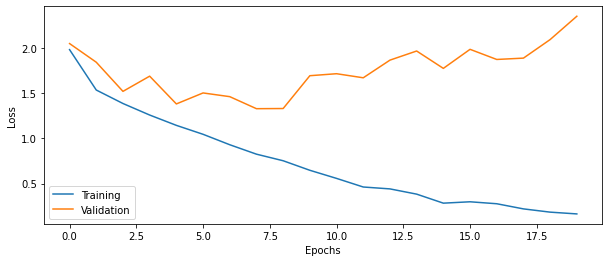

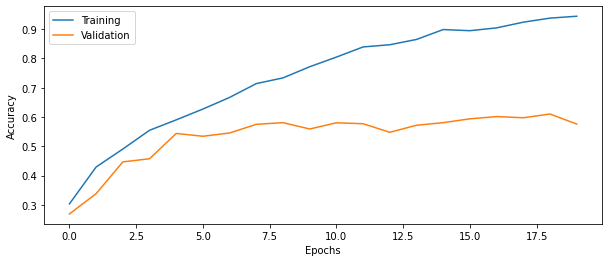

In [57]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

## Your best config

In [58]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)
seed(123)

# Setup some training parameters

# Build model
#model5 = build_CNN(input_shape=input_shape, n_conv_layers=3, n_filters=32, n_dense_layers=2, n_nodes=70, use_dropout=True, learning_rate=0.01)
model5 = build_CNN(input_shape, n_conv_layers=4, n_filters=64, n_dense_layers=1, n_nodes=500, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain,Ytrain, batch_size=batch_size, verbose=2, validation_data=(Xval,Yval), epochs=epochs)


Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 3s - loss: 2.4615 - accuracy: 0.2708 - val_loss: 4.9960 - val_accuracy: 0.1488
Epoch 2/20
 - 2s - loss: 1.8047 - accuracy: 0.3721 - val_loss: 3.9748 - val_accuracy: 0.1364
Epoch 3/20
 - 2s - loss: 1.5518 - accuracy: 0.4432 - val_loss: 2.6026 - val_accuracy: 0.2168
Epoch 4/20
 - 2s - loss: 1.3707 - accuracy: 0.5079 - val_loss: 1.7859 - val_accuracy: 0.4168
Epoch 5/20
 - 2s - loss: 1.2236 - accuracy: 0.5557 - val_loss: 1.4632 - val_accuracy: 0.4892
Epoch 6/20
 - 2s - loss: 1.0470 - accuracy: 0.6245 - val_loss: 1.3698 - val_accuracy: 0.5320
Epoch 7/20
 - 2s - loss: 0.9198 - accuracy: 0.6703 - val_loss: 1.3608 - val_accuracy: 0.5616
Epoch 8/20
 - 2s - loss: 0.7445 - accuracy: 0.7403 - val_loss: 1.4370 - val_accuracy: 0.5560
Epoch 9/20
 - 2s - loss: 0.7677 - accuracy: 0.7305 - val_loss: 1.7877 - val_accuracy: 0.5180
Epoch 10/20
 - 2s - loss: 0.6356 - accuracy: 0.7777 - val_loss: 1.2646 - val_accuracy: 0.6048
Epoch 11/20
 - 2s - l

In [59]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 73us/step
Test loss: 2.0598
Test accuracy: 0.6450


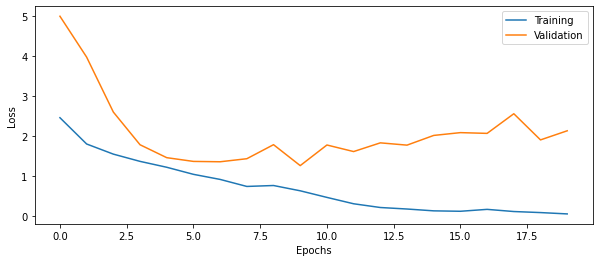

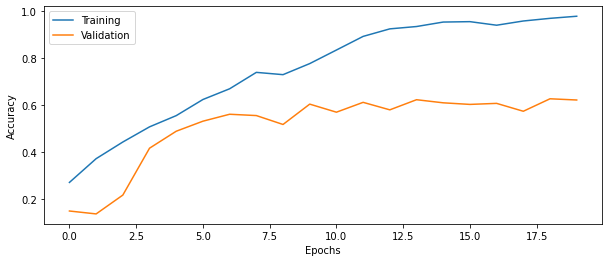

In [60]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

**Answer 23:** The test accuracy for rotated images is 0.2150 which is much lower compared to test images without rotation. Model 5 achieved prevliously test accuracy=0.6450. The reason of this poor performance is that the model is not trained on rotated images and thus can't predict them very accurately.

In [0]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

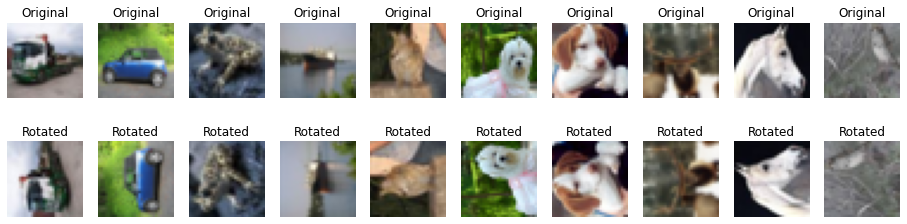

In [62]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [63]:
# Evaluate the trained model on rotated test set
score =  model5.evaluate(Xtest_rotated,Ytest,batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 86us/step
Test loss: 6.1849
Test accuracy: 0.2150


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [0]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [0]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(validation_split=0.2,rotation_range=30,horizontal_flip=True,vertical_flip=True)

# Setup a flow for training data, assume that we can fit all images into CPU memory

gen_train = datagen.flow(Xtrain, Ytrain, batch_size=100,subset= 'training')

# Setup a flow for validation data, assume that we can fit all images into CPU memory

gen_val = datagen.flow(Xtrain, Ytrain,batch_size=100,subset='validation')


## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

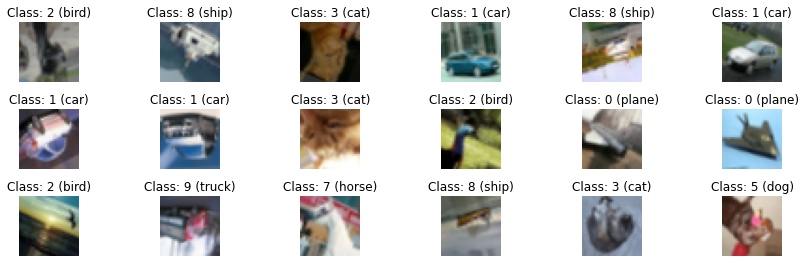

In [66]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)


plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

**Answer 25:** Comparing the two plots, model5 (without augmentation) training accuracy jumped much quicker (less epochs to reach a stable value) compared to model6 (with augmentation) training accuracy, which have a more steady increase. This difference may be due to the fact that model6 contains different versions of the same image and thus takes more time to train the model. We can add some more data augmentation variables in ImageDataGenerator,like the ones mentioned below.

Question 26: What other types of image augmentation can be applied, compared to what we use here?

**Answer 26:** We could also use ZCA whitening(via zca_whitening), image shifting (via width_shift_range and height_shift_range) , zoom (via zoom_range) or brightness (via brightness_range).

In [67]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = (32,32,3)
seed(123)

# Build model (your best config)
model6 = build_CNN(input_shape=input_shape, n_conv_layers=3, n_filters=32, n_dense_layers=2, n_nodes=70, use_dropout=True, learning_rate=0.01)

validation_split=0.2
    
# Train the model using on the fly augmentation
history6 = model6.fit_generator(gen_train, steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size, validation_data=gen_val,
                                validation_steps=len(Xtrain)*validation_split/batch_size, epochs=epochs)

Epoch 1/200
80/80 [==============================] - 5s 65ms/step - loss: 2.2659 - accuracy: 0.2179 - val_loss: 1.8472 - val_accuracy: 0.3040
Epoch 2/200
80/80 [==============================] - 4s 51ms/step - loss: 1.8843 - accuracy: 0.2909 - val_loss: 2.2056 - val_accuracy: 0.1835
Epoch 3/200
80/80 [==============================] - 4s 51ms/step - loss: 1.7765 - accuracy: 0.3275 - val_loss: 1.6850 - val_accuracy: 0.3200
Epoch 4/200
80/80 [==============================] - 4s 52ms/step - loss: 1.7194 - accuracy: 0.3590 - val_loss: 1.7324 - val_accuracy: 0.3835
Epoch 5/200
80/80 [==============================] - 4s 51ms/step - loss: 1.6825 - accuracy: 0.3809 - val_loss: 1.5466 - val_accuracy: 0.4265
Epoch 6/200
80/80 [==============================] - 4s 54ms/step - loss: 1.6221 - accuracy: 0.4050 - val_loss: 2.1227 - val_accuracy: 0.3980
Epoch 7/200
80/80 [==============================] - 4s 53ms/step - loss: 1.6080 - accuracy: 0.4051 - val_loss: 1.3408 - val_accuracy: 0.4500
Epoch 

In [68]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.1298
Test accuracy: 0.6835
Test loss: 2.8813
Test accuracy: 0.3245


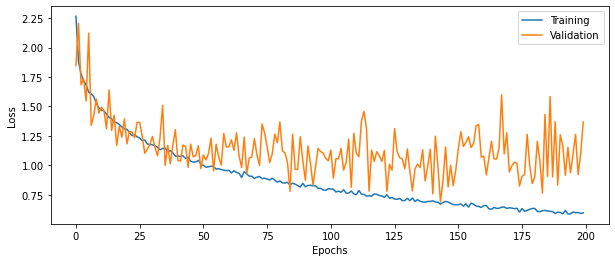

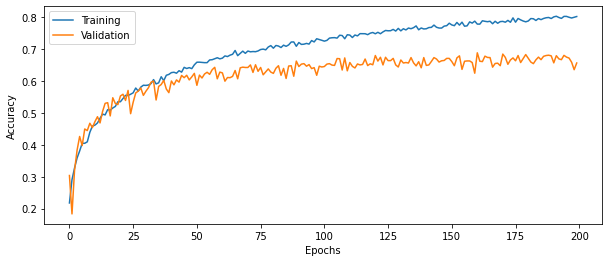

In [69]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [0]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

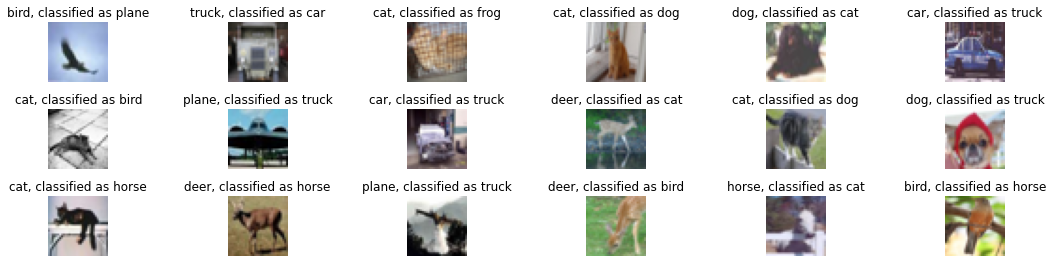

In [71]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

**Answer 27:** No, because the input shape that the CNN has been trained is for 32 by 32 images, so it cannot accept images of another size.

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

**Answer 28:** This could be done by using 'resize_images' from tensorflow https://www.tensorflow.org/api_docs/python/tf/keras/backend/resize_images.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

**Answer 29:** It has 48 convolutional layers.

Question 30: How many trainable parameters does the ResNet50 network have? 

**Answer 30:** 25,583,592 trainable parameters

Question 31: What is the size of the images that ResNet50 expects as input?

**Answer 31:**  224x224

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

**Answer 32:** Because it is computationally expensive to compute the second derivative when having a large number of trainable parameters,since second derivatives are often complicated.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?

Yes, all the predictions were correct. You can see in the printed results the probabilities which show how certain is the network for each image class.

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [72]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import numpy as np
from numpy import expand_dims

def image_pred(path):
    
  #ResNet50 model
    model = ResNet50(weights='imagenet')
  
  #load image
    original_image = image.load_img(path,target_size=(224,224)) #needs target size to resize the image we load
  #convert to numpy arrays
    original_image = img_to_array(original_image)

  #add extra dimension for the number of images
    original_image=np.expand_dims(original_image, axis=0) #used to add the number of images
    original_image= preprocess_input(original_image)

  #predictions
    prediction = model.predict(original_image)
  #list of tuples (class, description, probability)
    print('Predicted classes:', decode_predictions(prediction, top=3))

dog_pred = image_pred('dog.jpg')
cat_pred = image_pred('cat.jpg')
horse_pred= image_pred('horse.jpg')
baby_pred = image_pred('baby.jpg')
airplane_pred = image_pred('airplane.jpg')





40960/35363 [==================================] - 0s 0us/step
Predicted classes: [[('n02097474', 'Tibetan_terrier', 0.4469342), ('n02096437', 'Dandie_Dinmont', 0.12486098), ('n02099601', 'golden_retriever', 0.10187533)]]
Predicted classes: [[('n02123159', 'tiger_cat', 0.44420755), ('n02124075', 'Egyptian_cat', 0.31891584), ('n02123045', 'tabby', 0.2213454)]]
Predicted classes: [[('n02389026', 'sorrel', 0.14655511), ('n02100236', 'German_short-haired_pointer', 0.13777481), ('n02437312', 'Arabian_camel', 0.10595333)]]
Predicted classes: [[('n03825788', 'nipple', 0.96156573), ('n02834397', 'bib', 0.0076964004), ('n02869837', 'bonnet', 0.006311131)]]
Predicted classes: [[('n02690373', 'airliner', 0.9972464), ('n04592741', 'wing', 0.0025871743), ('n04552348', 'warplane', 0.00013224425)]]


In [73]:
model = ResNet50(weights='imagenet')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________